# SG-FIGS: Synergy-Guided FIGS Definitive 5-Method Comparison

This notebook demonstrates **Synergy-Guided FIGS (SG-FIGS)**, a method that uses PID (Partial Information Decomposition) synergy to guide oblique split feature pair selection in FIGS (Fast Interpretable Greedy-tree Sums).

**Methods compared:**
1. **FIGS** — Baseline axis-aligned FIGS (from imodels)
2. **RO-FIGS** — Random Oblique feature subsets
3. **SG-FIGS-Hard** — Synergy-constrained oblique splits from cliques/edges
4. **SG-FIGS-Soft** — Synergy-weighted probabilistic feature sampling
5. **Random-FIGS** — Ablation control with matched clique sizes

The experiment runs on the Iris dataset (150 samples, 4 features, 3 classes) using 5-fold CV with hyperparameter tuning on fold 0.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# imodels — NOT on Colab, always install
_pip('imodels==2.0.4')
# dit (PID computation) — install without deps, then add non-C deps manually
# pypoman/pycddlib need C headers (cddlib) — not needed for PID, skip them
_pip('--no-deps', 'dit==1.5')
_pip('boltons', 'debtcollector', 'lattices>=0.3.5', 'PLTable')

# numpy, pandas, sklearn, scipy, matplotlib, networkx — pre-installed on Colab, install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scikit-learn==1.6.1', 'scipy==1.16.3',
         'matplotlib==3.10.0', 'networkx==3.6.1', 'tabulate==0.9.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dit 1.5 requires pypoman, which is not installed.

[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dit 1.5 requires pypoman, which is not installed.
mlxtend 0.24.0 requires matplotlib>=3.10.8, but you have matplotlib 3.10.0 which is incompatible.
mlxtend 0.24.0 requires numpy>=2.3.5, but you have numpy 2.0.2 which is incompatible.
mlxtend 0.24.0 requires pandas>=2.3.3, but you have pandas 2.2.2 which is incompatible.
mlxtend 0.24.0 requires scikit-learn>=1.8.0, but you have scikit-learn 1.6.1 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json
import random
import time
import warnings
from collections import Counter
from pathlib import Path

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
if not hasattr(np, "alltrue"): np.alltrue = np.all
if not hasattr(np, "sometrue"): np.sometrue = np.any
if not hasattr(np, "product"): np.product = np.prod

from sklearn.linear_model import Ridge
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

print("All imports successful!")

All imports successful!


## Data Loading

Load the Iris dataset from GitHub (with local fallback). The data contains 75 curated examples with features, labels, and fold assignments for 5-fold cross-validation.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-b88b52-synergy-guided-oblique-splits-using-part/main/experiment_iter3_sg_figs_definit/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} dataset(s)")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 1 dataset(s)
  iris: 75 examples


## Configuration

All tunable parameters are defined here. Adjust these to trade off between runtime and result quality.

In [5]:
# --- Tunable parameters ---
# Original values used (fits within 5 min budget for Iris dataset)

MAX_SPLITS_GRID = [5, 10, 15, 25]  # hyperparameter tuning grid
N_FOLDS = 5  # 5-fold cross-validation
METHOD_NAMES = ["FIGS", "RO-FIGS", "SG-FIGS-Hard", "SG-FIGS-Soft", "Random-FIGS"]  # all 5 methods

RANDOM_SEED = 42
SYNERGY_N_BINS = 5  # discretization bins for PID synergy
SYNERGY_MAX_TIME = 120.0  # seconds budget for synergy computation
THRESHOLD_PERCENTILE = 75  # synergy graph edge threshold
MAX_DEPTH = 6  # max tree depth
NUM_REPETITIONS = 1  # oblique split attempts per node

print(f"Config: {len(METHOD_NAMES)} methods, {N_FOLDS} folds, "
      f"max_splits_grid={MAX_SPLITS_GRID}")

Config: 5 methods, 5 folds, max_splits_grid=[5, 10, 15, 25]


## 1. Data Parsing

Parse the JSON dataset into numpy arrays (X, y, folds) for training and evaluation.

In [6]:
def load_dataset(dataset_dict: dict) -> dict:
    """Parse one dataset dict from JSON into X, y, feature_names, folds."""
    examples = dataset_dict["examples"]
    first_input = json.loads(examples[0]["input"])
    feature_names = list(first_input.keys())
    n_features = len(feature_names)

    X = np.zeros((len(examples), n_features), dtype=np.float64)
    folds = np.zeros(len(examples), dtype=int)

    # Collect raw labels first to handle string labels
    raw_labels = [ex["output"] for ex in examples]
    unique_labels = sorted(set(raw_labels))

    # Build label mapping: try int conversion first, fall back to alphabetical
    label_map = {}
    try:
        for lbl in unique_labels:
            label_map[lbl] = int(lbl)
    except ValueError:
        for idx, lbl in enumerate(unique_labels):
            label_map[lbl] = idx

    # Remap to 0-based contiguous integers
    mapped_values = sorted(set(label_map.values()))
    remap = {v: i for i, v in enumerate(mapped_values)}

    y = np.zeros(len(examples), dtype=int)
    for i, ex in enumerate(examples):
        feat_dict = json.loads(ex["input"])
        X[i] = [feat_dict[fname] for fname in feature_names]
        y[i] = remap[label_map[ex["output"]]]
        folds[i] = int(ex["metadata_fold"])

    return {
        "X": X, "y": y, "feature_names": feature_names, "folds": folds,
        "n_classes": int(examples[0]["metadata_n_classes"]),
        "n_features": n_features,
        "domain": examples[0].get("metadata_domain", "unknown"),
        "label_map": label_map,
    }

# Parse all datasets from loaded data
datasets = {}
for ds in data["datasets"]:
    name = ds["dataset"]
    datasets[name] = load_dataset(ds)
    info = datasets[name]
    print(f"{name}: {info['X'].shape[0]} samples, "
          f"{info['n_features']} features, {info['n_classes']} classes")

iris: 75 samples, 4 features, 3 classes


## 2. PID Synergy Computation

Compute pairwise synergy between features using Partial Information Decomposition (PID). Synergy measures the information about the target that can only be obtained by jointly observing both features.

In [7]:
def discretize_features(X: np.ndarray, n_bins: int = 5) -> np.ndarray:
    """Discretize continuous features using quantile binning."""
    max_unique = max(len(np.unique(X[:, j])) for j in range(X.shape[1]))
    if max_unique <= n_bins:
        return X.astype(int)
    disc = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="quantile")
    X_disc = disc.fit_transform(X).astype(int)
    return X_disc


def compute_pairwise_synergy(
    xi_disc: np.ndarray, xj_disc: np.ndarray, y_disc: np.ndarray
) -> float:
    """Compute PID synergy between features i, j w.r.t. target y."""
    import dit
    from dit.pid import PID_BROJA, PID_WB

    if len(np.unique(xi_disc)) <= 1 or len(np.unique(xj_disc)) <= 1:
        return 0.0

    triples = list(zip(xi_disc.astype(int), xj_disc.astype(int), y_disc.astype(int)))
    counts = Counter(triples)
    total = len(triples)

    max_label = max(int(np.max(xi_disc)), int(np.max(xj_disc)), int(np.max(y_disc)))
    if max_label >= 10:
        outcomes = [f"{a} {b} {c}" for (a, b, c) in counts.keys()]
    else:
        outcomes = [f"{a}{b}{c}" for (a, b, c) in counts.keys()]
    pmf = [v / total for v in counts.values()]

    try:
        d = dit.Distribution(outcomes, pmf)
        n_joint_states = len(counts)
        if n_joint_states > 80:
            result = PID_WB(d)
        else:
            result = PID_BROJA(d)
        synergy = float(result[((0, 1),)])
    except Exception:
        synergy = 0.0

    return max(synergy, 0.0)


def build_synergy_matrix_fresh(
    X: np.ndarray, y: np.ndarray, n_bins: int = 5, max_time: float = 300.0
) -> np.ndarray:
    """Compute full pairwise synergy matrix with time budget."""
    X_disc = discretize_features(X, n_bins=n_bins)
    y_disc = y.astype(int)
    d = X_disc.shape[1]
    S = np.zeros((d, d))
    total_pairs = d * (d - 1) // 2
    computed = 0
    t0 = time.time()

    if d > 20:
        from sklearn.feature_selection import mutual_info_classif
        mi_scores = mutual_info_classif(X_disc, y_disc, discrete_features=True, random_state=42)
        top_features = np.argsort(mi_scores)[-20:]
        pairs = [(i, j) for idx_i, i in enumerate(sorted(top_features))
                 for j in sorted(top_features)[idx_i + 1:]]
        total_pairs = len(pairs)
        print(f"  High-dim ({d} features): synergy on top-20 by MI ({total_pairs} pairs)")
    else:
        pairs = [(i, j) for i in range(d) for j in range(i + 1, d)]

    for i, j in pairs:
        elapsed = time.time() - t0
        if elapsed > max_time:
            print(f"  Synergy time limit ({max_time:.0f}s) after {computed}/{total_pairs}")
            break
        S[i, j] = compute_pairwise_synergy(X_disc[:, i], X_disc[:, j], y_disc)
        S[j, i] = S[i, j]
        computed += 1

    print(f"  Computed {computed}/{total_pairs} synergy pairs in {time.time()-t0:.1f}s")
    return S

## 3. Synergy Graph & Feature Subset Extraction

Build a graph where edges connect features with high synergy, then extract cliques as feature subsets for oblique splits.

In [8]:
import networkx as nx

def extract_synergy_subsets(
    S: np.ndarray, threshold_percentile: int = 75
) -> tuple:
    """Extract feature subsets from synergy matrix.
    Returns (subsets, threshold, clique_sizes).
    """
    d = S.shape[0]
    vals = S[np.triu_indices(d, k=1)]
    pos_vals = vals[vals > 0]

    if len(pos_vals) == 0:
        return [], 0.0, [2]

    for pct in [threshold_percentile, 50, 25, 0]:
        tau = float(np.percentile(pos_vals, pct)) if pct > 0 else 0.0
        G = nx.Graph()
        G.add_nodes_from(range(d))
        for i in range(d):
            for j in range(i + 1, d):
                if S[i, j] > tau:
                    G.add_edge(i, j, weight=S[i, j])
        if G.number_of_edges() > 0:
            break

    if G.number_of_edges() == 0:
        return [], 0.0, [2]

    subsets = []
    clique_sizes = []
    for clique in nx.find_cliques(G):
        if 2 <= len(clique) <= 5:
            subsets.append(sorted(clique))
            clique_sizes.append(len(clique))

    for u, v in G.edges():
        pair = sorted([u, v])
        if pair not in subsets:
            subsets.append(pair)
            clique_sizes.append(2)

    if not clique_sizes:
        clique_sizes = [2]

    return subsets, tau, clique_sizes

## 4. Oblique FIGS Core

The ObliqueFIGSNode and Ridge-based oblique split primitive form the foundation of all SG-FIGS variants. Oblique splits use linear combinations of multiple features (guided by synergy) instead of single-feature axis-aligned splits.

In [9]:
class ObliqueFIGSNode:
    """Node supporting both axis-aligned and oblique splits."""
    __slots__ = [
        "feature", "features", "weights", "threshold", "value",
        "idxs", "is_root", "impurity_reduction", "tree_num",
        "left", "right", "depth", "is_oblique", "n_samples",
    ]
    def __init__(self, feature=None, features=None, weights=None, threshold=None,
                 value=None, idxs=None, is_root=False, impurity_reduction=None,
                 tree_num=None, left=None, right=None, depth=0, is_oblique=False,
                 n_samples=0):
        self.feature = feature; self.features = features; self.weights = weights
        self.threshold = threshold; self.value = value; self.idxs = idxs
        self.is_root = is_root; self.impurity_reduction = impurity_reduction
        self.tree_num = tree_num; self.left = left; self.right = right
        self.depth = depth; self.is_oblique = is_oblique; self.n_samples = n_samples


def fit_oblique_split_ridge(X, y_residuals, feature_indices):
    """Fit oblique split using Ridge regression + 1D stump."""
    X_sub = X[:, feature_indices]
    if X_sub.shape[0] < 5:
        return None
    col_std = np.std(X_sub, axis=0)
    if not np.any(col_std > 1e-12):
        return None
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_sub, y_residuals)
    weights = ridge.coef_.flatten()
    projections = X_sub @ weights
    if np.std(projections) < 1e-12:
        return None
    stump = DecisionTreeRegressor(max_depth=1, min_samples_leaf=2)
    stump.fit(projections.reshape(-1, 1), y_residuals)
    tree = stump.tree_
    if tree.feature[0] == -2 or tree.n_node_samples.shape[0] < 3:
        return None
    threshold = tree.threshold[0]
    left_mask = projections <= threshold
    if np.sum(left_mask) < 1 or np.sum(~left_mask) < 1:
        return None
    return {
        "features": np.array(feature_indices), "weights": weights,
        "threshold": threshold, "left_mask": left_mask,
        "value_left": np.mean(y_residuals[left_mask]),
        "value_right": np.mean(y_residuals[~left_mask]),
    }

print("ObliqueFIGSNode and oblique split primitive defined.")

ObliqueFIGSNode and oblique split primitive defined.


## 5. BaseFIGSOblique — FIGS Greedy Loop with Oblique Support

The core FIGS algorithm: greedily grows a sum of trees, at each step picking the split (axis-aligned or oblique) with the best impurity reduction.

In [10]:
class BaseFIGSOblique:
    """FIGS greedy tree-sum with oblique split support."""
    def __init__(self, max_splits=25, max_trees=None, max_depth=6,
                 min_impurity_decrease=0.0, num_repetitions=3, random_state=None):
        self.max_splits = max_splits; self.max_trees = max_trees
        self.max_depth = max_depth; self.min_impurity_decrease = min_impurity_decrease
        self.num_repetitions = num_repetitions; self.random_state = random_state
        self.trees_ = []; self.complexity_ = 0; self.scaler_ = None
        self.n_features_ = 0; self.feature_names_ = None

    def _get_feature_subsets_for_split(self, X, rng):
        raise NotImplementedError

    @staticmethod
    def _weighted_mse(y):
        return float(np.var(y) * len(y)) if len(y) > 0 else 0.0

    def _best_split_for_node(self, X, residuals, idxs, rng):
        idx_arr = np.where(idxs)[0]
        if len(idx_arr) < 5:
            return None
        X_node, y_node = X[idx_arr], residuals[idx_arr]
        parent_mse = self._weighted_mse(y_node)
        best, best_gain = None, self.min_impurity_decrease

        # Axis-aligned stump
        stump = DecisionTreeRegressor(max_depth=1, min_samples_leaf=2)
        stump.fit(X_node, y_node)
        t = stump.tree_
        if t.feature[0] >= 0 and t.n_node_samples.shape[0] >= 3:
            left_sub = X_node[:, t.feature[0]] <= t.threshold[0]
            if 2 <= np.sum(left_sub) <= len(idx_arr) - 2:
                gain = parent_mse - (self._weighted_mse(y_node[left_sub])
                                      + self._weighted_mse(y_node[~left_sub]))
                if gain > best_gain:
                    best_gain = gain
                    full_left = np.zeros(len(X), dtype=bool)
                    full_left[idx_arr[left_sub]] = True
                    best = {"is_oblique": False, "feature": int(t.feature[0]),
                            "threshold": float(t.threshold[0]), "gain": gain,
                            "left_mask": full_left,
                            "val_left": float(np.mean(y_node[left_sub])),
                            "val_right": float(np.mean(y_node[~left_sub])),
                            "n_left": int(np.sum(left_sub)),
                            "n_right": int(np.sum(~left_sub))}

        # Oblique splits
        for _ in range(self.num_repetitions):
            subsets = self._get_feature_subsets_for_split(X, rng)
            for feat_idx in subsets:
                if len(feat_idx) < 2:
                    continue
                obl = fit_oblique_split_ridge(X_node, y_node, feat_idx)
                if obl is None:
                    continue
                sub_left = obl["left_mask"]
                if np.sum(sub_left) < 2 or np.sum(~sub_left) < 2:
                    continue
                gain = parent_mse - (self._weighted_mse(y_node[sub_left])
                                      + self._weighted_mse(y_node[~sub_left]))
                if gain > best_gain:
                    best_gain = gain
                    full_left = np.zeros(len(X), dtype=bool)
                    full_left[idx_arr[sub_left]] = True
                    best = {"is_oblique": True, "features": obl["features"],
                            "weights": obl["weights"], "threshold": obl["threshold"],
                            "gain": gain, "left_mask": full_left,
                            "val_left": float(np.mean(y_node[sub_left])),
                            "val_right": float(np.mean(y_node[~sub_left])),
                            "n_left": int(np.sum(sub_left)),
                            "n_right": int(np.sum(~sub_left))}
        return best

    def fit(self, X, y, feature_names=None):
        rng = random.Random(self.random_state)
        np.random.seed(self.random_state if self.random_state else 42)
        n_samples, n_features = X.shape
        self.n_features_ = n_features; self.feature_names_ = feature_names
        self.scaler_ = MinMaxScaler(); X_s = self.scaler_.fit_transform(X)
        y_target = y.astype(float)
        all_idxs = np.ones(n_samples, dtype=bool)
        root_leaf = ObliqueFIGSNode(value=float(np.mean(y_target)), idxs=all_idxs,
                                     is_root=True, tree_num=0, depth=0, n_samples=n_samples)
        self.trees_ = [root_leaf]
        leaves = [(0, root_leaf, None, None)]
        total_splits = 0
        while total_splits < self.max_splits and leaves:
            predictions = self._compute_predictions(X_s)
            residuals = y_target - predictions
            scored = []
            for tree_idx, leaf, parent, side in leaves:
                if leaf.depth >= self.max_depth:
                    continue
                split_info = self._best_split_for_node(X_s, residuals, leaf.idxs, rng)
                if split_info is not None:
                    scored.append((split_info["gain"], tree_idx, leaf, parent, side, split_info))
            if not scored:
                max_trees_limit = self.max_trees if self.max_trees else min(self.max_splits, 10)
                if len(self.trees_) < max_trees_limit:
                    new_tree_idx = len(self.trees_)
                    new_root = ObliqueFIGSNode(value=float(np.mean(residuals)), idxs=all_idxs,
                                                is_root=True, tree_num=new_tree_idx, depth=0,
                                                n_samples=n_samples)
                    self.trees_.append(new_root)
                    leaves.append((new_tree_idx, new_root, None, None))
                    continue
                else:
                    break
            scored.sort(key=lambda x: x[0], reverse=True)
            best_gain, tree_idx, leaf, parent, side, info = scored[0]
            node = ObliqueFIGSNode(idxs=leaf.idxs, is_root=leaf.is_root, tree_num=tree_idx,
                                    depth=leaf.depth, impurity_reduction=best_gain,
                                    is_oblique=info["is_oblique"], n_samples=leaf.n_samples)
            if info["is_oblique"]:
                node.features = info["features"]; node.weights = info["weights"]
            else:
                node.feature = info["feature"]
            node.threshold = info["threshold"]
            left_idxs = info["left_mask"]; right_idxs = leaf.idxs & ~left_idxs
            left_leaf = ObliqueFIGSNode(value=info["val_left"], idxs=left_idxs,
                                         tree_num=tree_idx, depth=leaf.depth+1, n_samples=info["n_left"])
            right_leaf = ObliqueFIGSNode(value=info["val_right"], idxs=right_idxs,
                                          tree_num=tree_idx, depth=leaf.depth+1, n_samples=info["n_right"])
            node.left = left_leaf; node.right = right_leaf
            if parent is None:
                self.trees_[tree_idx] = node
            elif side == "left":
                parent.left = node
            else:
                parent.right = node
            leaves = [(ti, lf, p, s) for (ti, lf, p, s) in leaves if lf is not leaf]
            leaves.append((tree_idx, left_leaf, node, "left"))
            leaves.append((tree_idx, right_leaf, node, "right"))
            total_splits += 1
        # Final pass: update leaf values
        for t_idx, tree in enumerate(self.trees_):
            other_preds = np.zeros(n_samples)
            for j, other_tree in enumerate(self.trees_):
                if j != t_idx:
                    other_preds += self._predict_tree_vectorized(other_tree, X_s)
            self._update_leaf_values(tree, y_target - other_preds)
        self.complexity_ = total_splits
        return self

    def _update_leaf_values(self, node, residuals):
        if node is None: return
        if node.left is None and node.right is None:
            if node.idxs is not None and np.any(node.idxs):
                node.value = float(np.mean(residuals[node.idxs]))
            return
        self._update_leaf_values(node.left, residuals)
        self._update_leaf_values(node.right, residuals)

    def _compute_predictions(self, X):
        preds = np.zeros(X.shape[0])
        for tree in self.trees_:
            preds += self._predict_tree_vectorized(tree, X)
        return preds

    def _predict_tree_vectorized(self, root, X):
        preds = np.zeros(X.shape[0])
        stack = [(root, np.arange(X.shape[0]))]
        while stack:
            node, indices = stack.pop()
            if indices.size == 0 or node is None: continue
            if node.left is None and node.right is None:
                preds[indices] = float(node.value) if node.value is not None else 0.0
                continue
            if node.is_oblique and node.features is not None and node.weights is not None:
                proj = X[np.ix_(indices, node.features)] @ node.weights
                go_left = proj <= node.threshold
            elif node.feature is not None:
                go_left = X[indices, node.feature] <= node.threshold
            else:
                preds[indices] = float(node.value) if node.value is not None else 0.0
                continue
            stack.append((node.left, indices[go_left]))
            stack.append((node.right, indices[~go_left]))
        return preds

    def predict(self, X):
        return (self._compute_predictions(self.scaler_.transform(X)) > 0.5).astype(int)

    def predict_proba(self, X):
        preds = np.clip(self._compute_predictions(self.scaler_.transform(X)), 0.0, 1.0)
        return np.vstack((1 - preds, preds)).T

print("BaseFIGSOblique defined.")

BaseFIGSOblique defined.


## 6. Five Method Subclasses & Multi-Class Wrapper

Each method differs only in how it selects feature subsets for oblique splits:
- **RO-FIGS**: Random pairs
- **SG-FIGS-Hard**: Only synergy-graph cliques
- **SG-FIGS-Soft**: Synergy-weighted sampling
- **Random-FIGS**: Random with matched clique sizes (ablation)

In [11]:
class ROFIGSClassifier(BaseFIGSOblique):
    """RO-FIGS: Random Oblique feature subsets."""
    def __init__(self, subset_size=2, **kwargs):
        super().__init__(**kwargs); self.subset_size = subset_size
    def _get_feature_subsets_for_split(self, X, rng):
        d = X.shape[1]; k = min(self.subset_size, d)
        return [sorted(rng.sample(list(range(d)), k))]


class SGFIGSHardClassifier(BaseFIGSOblique):
    """SG-FIGS-Hard: Synergy-constrained oblique splits from cliques/edges."""
    def __init__(self, synergy_subsets=None, synergy_matrix=None, **kwargs):
        super().__init__(**kwargs)
        self.synergy_subsets = synergy_subsets or []; self.synergy_matrix = synergy_matrix
    def _get_feature_subsets_for_split(self, X, rng):
        if not self.synergy_subsets:
            d = X.shape[1]; i, j = rng.sample(range(d), 2); return [[i, j]]
        return [rng.choice(self.synergy_subsets)]


class SGFIGSSoftClassifier(BaseFIGSOblique):
    """SG-FIGS-Soft: Synergy-weighted probabilistic feature sampling."""
    def __init__(self, synergy_matrix=None, subset_size=2, **kwargs):
        super().__init__(**kwargs)
        self.synergy_matrix = synergy_matrix; self.subset_size = subset_size
    def _get_feature_subsets_for_split(self, X, rng):
        d = X.shape[1]; S = self.synergy_matrix; k = min(self.subset_size, d)
        if S is None or k < 2:
            return [sorted(rng.sample(range(d), k))]
        seed = rng.randint(0, d - 1); chosen = [seed]; remaining = set(range(d)) - {seed}
        while len(chosen) < k and remaining:
            candidates = list(remaining)
            scores = np.array([sum(S[c, ch] for ch in chosen)/len(chosen) for c in candidates]) + 1e-8
            probs = scores / scores.sum()
            idx = rng.choices(range(len(candidates)), weights=probs.tolist(), k=1)[0]
            chosen.append(candidates[idx]); remaining.discard(candidates[idx])
        return [sorted(chosen)]


class RandomFIGSAblation(BaseFIGSOblique):
    """Random-FIGS: Ablation control with matched clique sizes."""
    def __init__(self, clique_sizes=None, **kwargs):
        super().__init__(**kwargs); self.clique_sizes = clique_sizes or [2]
    def _get_feature_subsets_for_split(self, X, rng):
        d = X.shape[1]; k = max(min(rng.choice(self.clique_sizes), d), 2)
        return [sorted(rng.sample(range(d), k))]


class MultiClassObliqueWrapper:
    """One-vs-Rest wrapper for oblique FIGS methods on multi-class problems."""
    def __init__(self, base_cls, **kwargs):
        self.base_cls = base_cls; self.kwargs = kwargs
        self.models = {}; self.classes_ = None; self.scaler_ = None
    def fit(self, X, y, feature_names=None):
        self.classes_ = np.unique(y)
        for c in self.classes_:
            y_bin = (y == c).astype(float)
            model = self.base_cls(**self.kwargs)
            model.fit(X, y_bin, feature_names=feature_names)
            self.models[c] = model
        self.scaler_ = self.models[self.classes_[0]].scaler_
        return self
    def predict(self, X):
        scores = np.column_stack([
            self.models[c]._compute_predictions(self.models[c].scaler_.transform(X))
            for c in self.classes_])
        return self.classes_[np.argmax(scores, axis=1)]
    def predict_proba(self, X):
        scores = np.column_stack([
            self.models[c]._compute_predictions(self.models[c].scaler_.transform(X))
            for c in self.classes_])
        scores = scores - scores.max(axis=1, keepdims=True)
        exp_scores = np.exp(scores)
        return exp_scores / exp_scores.sum(axis=1, keepdims=True)
    @property
    def trees_(self):
        return [t for m in self.models.values() for t in m.trees_]
    @property
    def complexity_(self):
        return sum(m.complexity_ for m in self.models.values())


class FIGSBaselineWrapper:
    """Wrapper around imodels FIGSClassifier."""
    def __init__(self, max_splits=25):
        from imodels import FIGSClassifier
        self.model = FIGSClassifier(max_rules=max_splits)
        self.max_splits = max_splits; self.trees_ = []; self.complexity_ = 0
    def fit(self, X, y, feature_names=None):
        self.model.fit(X, y, feature_names=feature_names)
        self.trees_ = self.model.trees_ if hasattr(self.model, "trees_") else []
        self.complexity_ = self.model.complexity_ if hasattr(self.model, "complexity_") else 0
        return self
    def predict(self, X):
        return self.model.predict(X).astype(int)
    def predict_proba(self, X):
        return self.model.predict_proba(X)

print("All 5 method classes + MultiClassObliqueWrapper defined.")

All 5 method classes + MultiClassObliqueWrapper defined.


## 7. Evaluation Metrics & Model Factory

Metrics include balanced accuracy, split interpretability score (fraction of oblique splits using high-synergy feature pairs), and model complexity.

In [12]:
def collect_oblique_nodes(node, result):
    if node is None: return
    if not isinstance(node, ObliqueFIGSNode): return
    if node.is_oblique and (node.left is not None or node.right is not None):
        result.append(node)
    if hasattr(node, "left"): collect_oblique_nodes(node.left, result)
    if hasattr(node, "right"): collect_oblique_nodes(node.right, result)

def count_total_nodes(node):
    if node is None: return 0
    if not hasattr(node, "left") or not hasattr(node, "right"): return 0
    if node.left is None and node.right is None: return 0
    return 1 + count_total_nodes(node.left) + count_total_nodes(node.right)

def count_trees_and_splits(model):
    if isinstance(model, MultiClassObliqueWrapper):
        return (sum(len(m.trees_) for m in model.models.values()),
                sum(m.complexity_ for m in model.models.values()))
    if hasattr(model, "trees_"):
        return len(model.trees_), sum(count_total_nodes(t) for t in model.trees_)
    if hasattr(model, "model") and hasattr(model.model, "trees_"):
        return (len(model.model.trees_),
                model.model.complexity_ if hasattr(model.model, "complexity_") else 0)
    return 0, 0

def compute_split_interpretability_score(model, synergy_matrix):
    """Fraction of oblique splits whose features have above-median synergy."""
    d = synergy_matrix.shape[0]
    all_synergies = synergy_matrix[np.triu_indices(d, k=1)]
    median_synergy = float(np.median(all_synergies))
    trees = []
    if isinstance(model, MultiClassObliqueWrapper): trees = model.trees_
    elif hasattr(model, "trees_"): trees = model.trees_
    else: return float("nan")
    oblique_splits = []
    for tree_root in trees:
        if isinstance(tree_root, ObliqueFIGSNode):
            collect_oblique_nodes(tree_root, oblique_splits)
    if not oblique_splits: return float("nan")
    above_median, total_scored = 0, 0
    for node in oblique_splits:
        feats = node.features
        if feats is None or len(feats) < 2: continue
        active = ([feats[i] for i in range(len(feats)) if abs(node.weights[i]) > 1e-10]
                  if node.weights is not None else list(feats))
        if len(active) < 2: continue
        pair_syns = [synergy_matrix[int(active[ii]), int(active[jj])]
                     for ii in range(len(active)) for jj in range(ii+1, len(active))
                     if int(active[ii]) < d and int(active[jj]) < d]
        if pair_syns:
            if np.mean(pair_syns) > median_synergy: above_median += 1
            total_scored += 1
    return above_median / total_scored if total_scored > 0 else float("nan")


def create_model(method_name, max_splits, synergy_subsets, synergy_matrix,
                 clique_sizes, median_clique_size, is_binary):
    """Create a model by method name, with multi-class wrapping if needed."""
    oblique_kwargs = {"max_splits": max_splits, "random_state": RANDOM_SEED,
                      "num_repetitions": NUM_REPETITIONS, "max_depth": MAX_DEPTH}
    if method_name == "FIGS":
        return FIGSBaselineWrapper(max_splits=max_splits)
    elif method_name == "RO-FIGS":
        cls, kwargs = ROFIGSClassifier, {**oblique_kwargs, "subset_size": median_clique_size}
    elif method_name == "SG-FIGS-Hard":
        cls = SGFIGSHardClassifier
        kwargs = {**oblique_kwargs, "synergy_subsets": synergy_subsets,
                  "synergy_matrix": synergy_matrix}
    elif method_name == "SG-FIGS-Soft":
        cls = SGFIGSSoftClassifier
        kwargs = {**oblique_kwargs, "synergy_matrix": synergy_matrix,
                  "subset_size": median_clique_size}
    elif method_name == "Random-FIGS":
        cls = RandomFIGSAblation
        kwargs = {**oblique_kwargs, "clique_sizes": clique_sizes}
    else:
        raise ValueError(f"Unknown method: {method_name}")
    if method_name != "FIGS":
        return cls(**kwargs) if is_binary else MultiClassObliqueWrapper(base_cls=cls, **kwargs)

print("Evaluation metrics and model factory defined.")

Evaluation metrics and model factory defined.


## 8. Run Experiment

For each dataset: compute synergy matrix, extract feature subsets, then evaluate each method with hyperparameter tuning (fold 0) followed by N-fold cross-validation.

In [13]:
all_results = {}
total_start = time.time()

for ds_name, ds in datasets.items():
    X, y = ds["X"], ds["y"]
    is_binary = ds["n_classes"] == 2
    feature_names = ds["feature_names"]
    print(f"\n{'='*60}")
    print(f"Dataset: {ds_name} ({X.shape[0]} samples, {X.shape[1]} features, "
          f"{ds['n_classes']} classes)")
    print(f"{'='*60}")

    # Compute synergy matrix from scratch
    print("Computing PID synergy matrix...")
    train_mask = ds["folds"] != 0
    synergy_matrix = build_synergy_matrix_fresh(
        X[train_mask], y[train_mask],
        n_bins=SYNERGY_N_BINS, max_time=SYNERGY_MAX_TIME)
    if synergy_matrix.shape[0] < X.shape[1]:
        S_full = np.zeros((X.shape[1], X.shape[1]))
        n = synergy_matrix.shape[0]
        S_full[:n, :n] = synergy_matrix
        synergy_matrix = S_full

    # Extract synergy subsets
    synergy_subsets, tau, clique_sizes = extract_synergy_subsets(
        synergy_matrix, threshold_percentile=THRESHOLD_PERCENTILE)
    median_clique_size = max(int(np.median(clique_sizes)) if clique_sizes else 2, 2)
    print(f"Synergy: {len(synergy_subsets)} subsets, "
          f"median_clique={median_clique_size}, threshold={tau:.4f}")

    # Evaluate each method
    ds_results = {}
    tuning_grid = MAX_SPLITS_GRID if is_binary else [ms for ms in MAX_SPLITS_GRID if ms <= 15]
    if not tuning_grid:
        tuning_grid = [5]

    for method_name in METHOD_NAMES:
        method_start = time.time()
        print(f"\n  {method_name}:")

        # Hyperparameter tuning on fold 0
        best_config, best_val_score = None, -1.0
        for max_splits in tuning_grid:
            try:
                train_idx = ds["folds"] != 0
                val_idx = ds["folds"] == 0
                if np.sum(train_idx) < 5 or np.sum(val_idx) < 2: continue
                model = create_model(method_name=method_name, max_splits=max_splits,
                                     synergy_subsets=synergy_subsets, synergy_matrix=synergy_matrix,
                                     clique_sizes=clique_sizes, median_clique_size=median_clique_size,
                                     is_binary=is_binary)
                model.fit(X[train_idx], y[train_idx], feature_names=feature_names)
                y_pred = model.predict(X[val_idx])
                val_score = balanced_accuracy_score(y[val_idx], y_pred)
                if val_score > best_val_score:
                    best_val_score = val_score; best_config = max_splits
            except Exception as e:
                print(f"    tuning ms={max_splits} failed: {e}")
        if best_config is None: best_config = 10
        print(f"    best_max_splits={best_config} (val_acc={best_val_score:.4f})")

        # N-fold evaluation
        fold_results = []
        for fold_id in range(N_FOLDS):
            try:
                test_idx = ds["folds"] == fold_id
                train_idx = ~test_idx
                if np.sum(train_idx) < 5 or np.sum(test_idx) < 2: continue
                model = create_model(method_name=method_name, max_splits=best_config,
                                     synergy_subsets=synergy_subsets, synergy_matrix=synergy_matrix,
                                     clique_sizes=clique_sizes, median_clique_size=median_clique_size,
                                     is_binary=is_binary)
                model.fit(X[train_idx], y[train_idx], feature_names=feature_names)
                y_pred = model.predict(X[test_idx])
                bal_acc = balanced_accuracy_score(y[test_idx], y_pred)
                n_trees, n_splits = count_trees_and_splits(model)
                interp = compute_split_interpretability_score(model, synergy_matrix)
                fold_results.append({"fold": fold_id, "balanced_accuracy": round(bal_acc, 6),
                                      "n_splits": n_splits, "n_trees": n_trees,
                                      "interpretability_score": round(interp, 4) if not np.isnan(interp) else None})
            except Exception as e:
                print(f"    fold {fold_id} failed: {e}")

        if fold_results:
            accs = [r["balanced_accuracy"] for r in fold_results]
            interps = [r["interpretability_score"] for r in fold_results if r["interpretability_score"] is not None]
            ds_results[method_name] = {
                "best_max_splits": best_config,
                "fold_results": fold_results,
                "mean_balanced_accuracy": round(float(np.mean(accs)), 6),
                "std_balanced_accuracy": round(float(np.std(accs)), 6),
                "mean_interpretability": round(float(np.mean(interps)), 4) if interps else None,
            }
            print(f"    acc={ds_results[method_name]['mean_balanced_accuracy']:.4f} "
                  f"±{ds_results[method_name]['std_balanced_accuracy']:.4f}, "
                  f"interp={ds_results[method_name].get('mean_interpretability', 'N/A')}, "
                  f"time={time.time()-method_start:.1f}s")
        else:
            ds_results[method_name] = {"error": "all folds failed"}

    all_results[ds_name] = ds_results

total_time = time.time() - total_start
print(f"\n{'='*60}")
print(f"Total experiment time: {total_time:.1f}s ({total_time/60:.1f} min)")


Dataset: iris (75 samples, 4 features, 3 classes)
Computing PID synergy matrix...


  Computed 6/6 synergy pairs in 85.5s
Synergy: 2 subsets, median_clique=2, threshold=0.2703

  FIGS:
    best_max_splits=5 (val_acc=0.9333)


    acc=0.9733 ±0.0327, interp=None, time=0.2s

  RO-FIGS:


    best_max_splits=5 (val_acc=0.9333)


    acc=0.8933 ±0.0800, interp=0.2, time=0.9s

  SG-FIGS-Hard:


    best_max_splits=5 (val_acc=0.9333)


    acc=0.9467 ±0.0267, interp=1.0, time=0.9s

  SG-FIGS-Soft:


    best_max_splits=5 (val_acc=0.9333)


    acc=0.9467 ±0.0267, interp=0.7, time=0.9s

  Random-FIGS:


    best_max_splits=5 (val_acc=0.9333)


    acc=0.9467 ±0.0267, interp=0.1875, time=0.9s

Total experiment time: 89.4s (1.5 min)


## 9. Results Visualization

Summary table and bar chart comparing methods on balanced accuracy and interpretability.


RESULTS SUMMARY
Method                  Acc      Std   Interp
--------------------------------------------
FIGS                 0.9733   0.0000      N/A
RO-FIGS              0.8933   0.0000   0.2000
SG-FIGS-Hard         0.9467   0.0000   1.0000
SG-FIGS-Soft         0.9467   0.0000   0.7000
Random-FIGS          0.9467   0.0000   0.1875


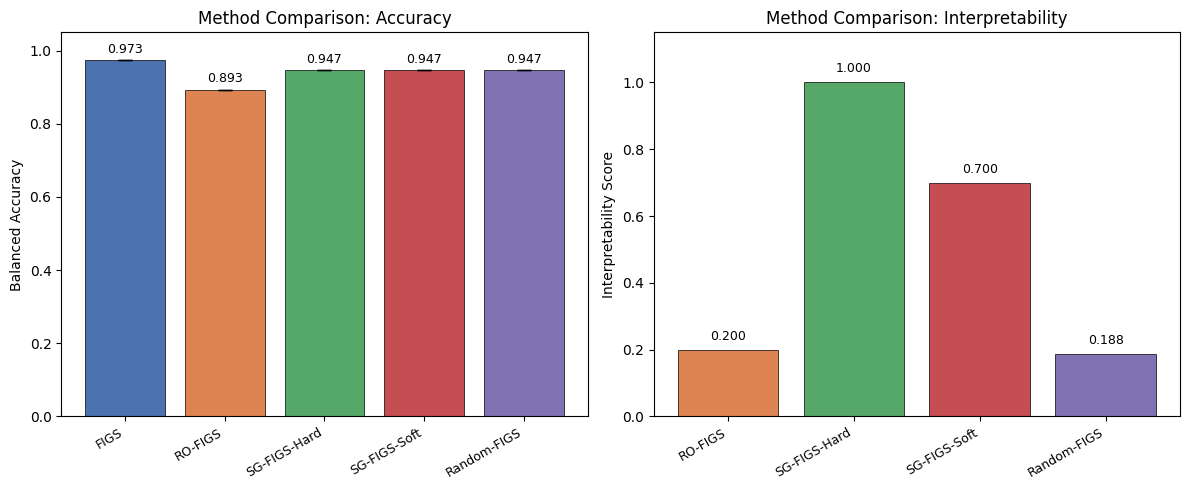


Visualization saved to sg_figs_comparison.png


In [14]:
# --- Results Summary Table ---
print(f"\n{'='*60}")
print("RESULTS SUMMARY")
print(f"{'='*60}")
print(f"{'Method':<18} {'Acc':>8} {'Std':>8} {'Interp':>8}")
print("-" * 44)

method_accs = {}
method_interps = {}
for ds_name, ds_results in all_results.items():
    for method_name in METHOD_NAMES:
        mr = ds_results.get(method_name, {})
        acc = mr.get("mean_balanced_accuracy")
        interp = mr.get("mean_interpretability")
        if acc is not None:
            method_accs.setdefault(method_name, []).append(acc)
        if interp is not None:
            method_interps.setdefault(method_name, []).append(interp)

for mn in METHOD_NAMES:
    accs = method_accs.get(mn, [])
    interps = method_interps.get(mn, [])
    avg_acc = np.mean(accs) if accs else float("nan")
    std_acc = np.std(accs) if accs else float("nan")
    avg_interp = np.mean(interps) if interps else float("nan")
    print(f"{mn:<18} {avg_acc:>8.4f} {std_acc:>8.4f} "
          f"{avg_interp:>8.4f}" if not np.isnan(avg_interp) else
          f"{mn:<18} {avg_acc:>8.4f} {std_acc:>8.4f} {'N/A':>8}")

# --- Bar Chart ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
methods_with_acc = [mn for mn in METHOD_NAMES if mn in method_accs]
acc_means = [np.mean(method_accs[mn]) for mn in methods_with_acc]
acc_stds = [np.std(method_accs[mn]) for mn in methods_with_acc]
colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52', '#8172B3'][:len(methods_with_acc)]

axes[0].bar(range(len(methods_with_acc)), acc_means, yerr=acc_stds,
            color=colors, capsize=5, edgecolor='black', linewidth=0.5)
axes[0].set_xticks(range(len(methods_with_acc)))
axes[0].set_xticklabels(methods_with_acc, rotation=30, ha='right', fontsize=9)
axes[0].set_ylabel('Balanced Accuracy')
axes[0].set_title('Method Comparison: Accuracy')
axes[0].set_ylim(0, 1.05)
for i, (m, s) in enumerate(zip(acc_means, acc_stds)):
    axes[0].text(i, m + s + 0.02, f'{m:.3f}', ha='center', fontsize=9)

# Interpretability comparison
methods_with_interp = [mn for mn in METHOD_NAMES if mn in method_interps]
if methods_with_interp:
    interp_means = [np.mean(method_interps[mn]) for mn in methods_with_interp]
    interp_colors = [colors[METHOD_NAMES.index(mn)] for mn in methods_with_interp]
    axes[1].bar(range(len(methods_with_interp)), interp_means,
                color=interp_colors, edgecolor='black', linewidth=0.5)
    axes[1].set_xticks(range(len(methods_with_interp)))
    axes[1].set_xticklabels(methods_with_interp, rotation=30, ha='right', fontsize=9)
    axes[1].set_ylabel('Interpretability Score')
    axes[1].set_title('Method Comparison: Interpretability')
    axes[1].set_ylim(0, 1.15)
    for i, m in enumerate(interp_means):
        axes[1].text(i, m + 0.03, f'{m:.3f}', ha='center', fontsize=9)
else:
    axes[1].text(0.5, 0.5, 'No interpretability data\n(FIGS has no oblique splits)',
                 ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_title('Method Comparison: Interpretability')

plt.tight_layout()
plt.savefig('sg_figs_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nVisualization saved to sg_figs_comparison.png")